# Distance between species trees --using the copy number matrix for marker gene selection

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import re
import pandas as pd

In [2]:
from skbio import TreeNode

In [3]:
import dendropy
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance, weighted_robinson_foulds_distance

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Functions

In [5]:
def shared_taxa(tree1, tree2):
    taxa1 = {node.taxon.label for node in tree1.leaf_node_iter()}
    taxa2 = {node.taxon.label for node in tree2.leaf_node_iter()}
    return list(taxa1.intersection(taxa2)), taxa1, taxa2

In [6]:
def RF_distance(treeA, treeB, norm = True, **kwargs):
    
    treeA_copy, treeB_copy = dendropy.Tree(treeA), dendropy.Tree(treeB)
    
    # Prune trees such that they contain the same taxa, otherwise RF is much larger
    taxa_to_keep, taxa1, taxa2 = shared_taxa(treeA_copy, treeB_copy)
    if len(taxa_to_keep) < len(taxa1) or len(taxa_to_keep) < len(taxa2):
        treeA_copy.retain_taxa_with_labels(taxa_to_keep)
        treeB_copy.retain_taxa_with_labels(taxa_to_keep)
        
    # Update bipartition
    treeA_copy.update_bipartitions()
    treeB_copy.update_bipartitions()
    
    # Assuming trees share the same taxon name space
    rf = unweighted_robinson_foulds_distance(treeA_copy, treeB_copy)
    if norm:
        # Normalize by the maximal possible distance: which is the sum of internal branches
        # between both trees. Alternatively, if both trees are unrooted and binary, the sum
        # is always 2n - 6, where n is the number of tips in the tree.
        max_dist = 2 * len(taxa_to_keep) - 6
        # Number of internal branches
        # n, m = num_internal_branches(treeA_copy), num_internal_branches(treeB_copy)
        if len(taxa_to_keep) > 3:
            rf = rf / max_dist
        else:
            rf = 0.0

    # Ratio between species in inferred to actual species tree
    ratio_sps = len(taxa2) / len(taxa1)
    
    return rf, ratio_sps

Generate metadata file for each replicate containing: number of species and number of gene families

In [9]:
df = pd.read_csv(f'./realistic/input_data/metadata_simulations.tsv', sep = '\t', index_col = 0)
df.shape

(24, 2)

Parameters from simulations

### Batch plots

In [15]:
def load_data_calculate_distance(dataPathIn, noise, ps, replicates, shuffled):
    # To store results
    mean_distances_trees = np.zeros((11, len(ps)))
    std_distances_trees = np.zeros((11, len(ps)))
    mean_ratio_sps = np.zeros((11, len(ps)))
    std_ratio_sps = np.zeros((11, len(ps)))
    mean_prop_nodes_confident = np.zeros((11, len(ps)))
    std_prop_nodes_confident = np.zeros((11, len(ps)))
    # Load data
    for i in range(11): # Since we only have 11 values for k
        for j, p in enumerate(ps):
            taxon_namespace = dendropy.TaxonNamespace()
            distances = np.zeros(len(replicates))
            ratios = np.zeros(len(replicates))
            lpp = np.zeros(len(replicates))
            for idx, rep in enumerate(replicates):
                # Parameters of simulation
                n = df.loc[rep]['num_gene_famlies_filtered']
                ks = np.geomspace(10, n - 1, dtype = int, num = 11)
                # Load trees
                if not shuffled:
                    path_inferred_tree = f'./realistic/input_data/inferred_trees/nid_sps_k_{ks[i]}_p_{p}_noise_0.05_rep_{rep}_astral-pro2.nwk'
                    path_metadata = f'./realistic/input_data/inferred_trees/metadata_sps_k_{ks[i]}_p_{p}_noise_0.05_rep_{rep}_astral-pro2.tsv'
                else:
                    path_inferred_tree = f'./realistic/input_data/inferred_trees/nid_sps_shuffled_k_{ks[i]}_p_{p}_noise_{noise}_rep_{rep}_astral-pro2.nwk'
                    path_metadata = f'./realistic/input_data/inferred_trees/metadata_sps_shuffled_k_{ks[i]}_p_{p}_noise_{noise}_rep_{rep}_astral-pro2.tsv'
                # Load real species tree
                actual_tree = dendropy.Tree.get(path = f'{dataPathIn}/replicate_{rep}/ExtantTree.nwk', 
                            schema = 'newick', taxon_namespace = taxon_namespace)
                # Load inferred species tree
                inferred_tree = dendropy.Tree.get(path = path_inferred_tree, 
                          schema = 'newick', taxon_namespace = taxon_namespace)
                # Load tree metadata
                metadata_tree = pd.read_csv(path_metadata,
                                       sep = '\t', index_col = 0)
                # Calculate distance
                distances[idx], ratios[idx] = RF_distance(actual_tree, inferred_tree)
                # Calculate proportion of confident nodes (lpp > 0.95)
                datum = metadata_tree['pp1'].values
                lpp[idx] = np.sum(datum >= 0.95) / len(datum)
            # Calculate mean and std of replicates
            mean_distances_trees[i, j] = distances.mean()
            std_distances_trees[i, j] = distances.std()
            mean_ratio_sps[i, j] = ratios.mean()
            std_ratio_sps[i, j] = ratios.std()
            mean_prop_nodes_confident[i, j] = lpp.mean()
            std_prop_nodes_confident[i, j] = lpp.std()

    return mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps, mean_prop_nodes_confident, std_prop_nodes_confident

In [16]:
replicates = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25]
ps = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
noises = [0.0, 0.25, 0.5]

In [17]:
dataPathIn = f'./realistic/input_data/real_trees'

In [18]:
%%time
results = {}
for noise in noises:
    print(f'Noise: {noise}')
    if noise == 0.0:
        mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps, mean_prop_nodes_confident, std_prop_nodes_confident = load_data_calculate_distance(dataPathIn, noise, ps, replicates, shuffled = False)
    else:
        mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps, mean_prop_nodes_confident, std_prop_nodes_confident = load_data_calculate_distance(dataPathIn, noise, ps, replicates, shuffled = True)
    
    results[noise] = [mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps, mean_prop_nodes_confident, std_prop_nodes_confident]

Noise: 0.0
Noise: 0.25
Noise: 0.5
CPU times: user 18min 10s, sys: 11.1 s, total: 18min 21s
Wall time: 18min 32s


### Plots

In [19]:
X, Y = np.meshgrid(ps, np.arange(11))
norm = mcolors.Normalize(vmin = 0, vmax = 1.0)

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_46841/536148510.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'../figures/figure_2B_nrf.svg')


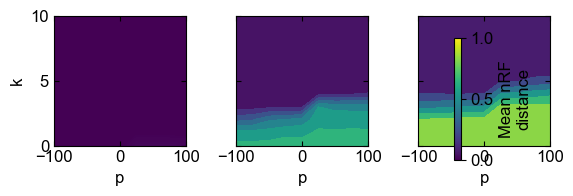

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = len(noises), figsize = (5.9, 2.12),
                        sharex = True, sharey = True)
j = 0
for noise, data in results.items():
    im = axes[j].contourf(X, Y, data[0], norm = norm, levels = 7)
    axes[j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[j].set_xlabel('p')
    axes[0].set_ylabel('k')
#     axes[j].set_title(f'Noise: {noise}')
    j += 1
    
# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'viridis'), ax = axes.ravel().tolist(), 
                    shrink = 0.75,
                   label = f'Mean nRF\ndistance')

fig.savefig(f'./figures/figure_2B_nrf.svg')

plt.show()

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_46841/682667002.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'../figures/figure_S2C_nrf.svg')


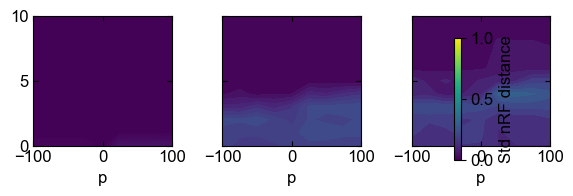

In [23]:
fig, axes = plt.subplots(nrows = 1, ncols = len(noises), figsize = (5.9, 2.12),
                        sharex = True, sharey = True)
j = 0
for noise, data in results.items():
    im = axes[j].contourf(X, Y, data[1], norm = norm, levels = 7)
    axes[j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[j].set_xlabel('p')
#     axes[j].set_ylabel('k')
#     axes[j].set_title(f'Noise: {noise}')
    j += 1
    
# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'viridis'), ax = axes.ravel().tolist(), shrink = 0.75,
                   label = 'Std nRF distance')

fig.savefig(f'./figures/figure_S2C_nrf.svg')

plt.show()

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_46841/1269611684.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'../figures/figure_2B_lpp.svg')


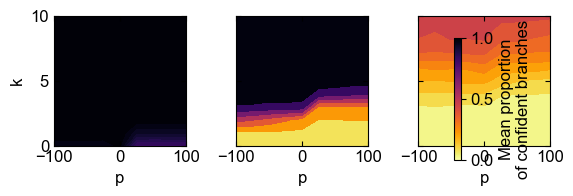

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = len(noises), figsize = (5.9, 2.12),
                        sharex = True, sharey = True)
j = 0
for noise, data in results.items():
    im = axes[j].contourf(X, Y, data[4], norm = norm, levels = 7, cmap = 'inferno_r')
    axes[j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[j].set_xlabel('p')
    axes[0].set_ylabel('k')
#     axes[j].set_title(f'Noise: {noise}')
    j += 1
    
# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'inferno_r'), ax = axes.ravel().tolist(), shrink = 0.75,
                   label = f'Mean proportion\nof confident branches')

fig.savefig(f'./figures/figure_2B_lpp.svg')

plt.show()

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_46841/2616429776.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'../figures/figure_S2C_lpp.svg')


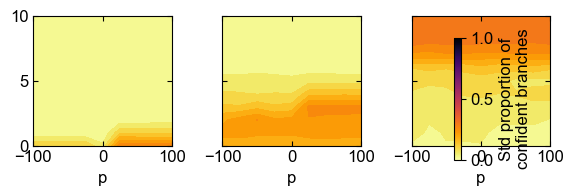

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = len(noises), figsize = (5.9, 2.12),
                        sharex = True, sharey = True)
j = 0
for noise, data in results.items():
    im = axes[j].contourf(X, Y, data[5], norm = norm, levels = 7, cmap = 'inferno_r')
    axes[j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[j].set_xlabel('p')
#     axes[j].set_ylabel('k')
#     axes[j].set_title(f'Noise: {noise}')
    j += 1
    
# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'inferno_r'), ax = axes.ravel().tolist(), shrink = 0.75,
                   label = 'Std proportion of\nconfident branches')

fig.savefig(f'./figures/figure_S2C_lpp.svg')

plt.show()

# Gene family space

In [26]:
def load_gene_families(tree, path):
    '''
    Function that loads the gene families of ZOMBI simulations
    as an edge list
    Parameters
    ----------
        tree: skbio TreeNode containing species
        path: str containing the path to the directory that has genomic information
    Returns
    -------
        edges: Arrays containing the genome and gene family
    '''
    genomes, families = [], []
    for node in tree.tips():
        file = os.path.join(path, f'output/G/Genomes/{node.name}_GENOME.tsv')
        with open(file, 'r') as f:
            for line in f:
                if line[0] != 'P':
                    gene_family = line.strip().split('\t')[1]
                    genomes.append(node.name)
                    families.append(gene_family)
    return np.array(families), np.array(genomes)

In [27]:
def adjMatv2(edges_ogs, edges_genomes):
    # Get unique elements
    ogs, ogs_indices = np.unique(edges_ogs, return_inverse = True)
    genomes, genomes_indices = np.unique(edges_genomes, return_inverse = True)
    # Calculate bin counts for each combination of indices
    counts = np.bincount(ogs_indices * len(genomes) + genomes_indices, minlength = len(ogs) * len(genomes))
    # Reshape counts as adjacency matrix
    adj = counts.reshape(len(ogs), len(genomes))
    return adj, genomes, ogs

In [28]:
def remove_genes(adj_mod):
    '''
    Function that removes genes if:
        present in less than 4 genomes/species
    '''
    remove = np.array([i for i in range(len(adj_mod)) if adj_mod[i].sum() < 4])
    return remove

Load data

In [29]:
tree = TreeNode.read(f'./realistic/zombi/replicate_1/output/T/ExtantTree.nwk')
print(tree.count(tips = True))

226


In [30]:
edges_families, edges_genomes = load_gene_families(tree, f'./realistic/zombi/replicate_1')

Build copy number matrix

In [31]:
adj, genomes, ogs = adjMatv2(edges_families, edges_genomes)

Reformat matrix

In [32]:
adj1 = adj

In [33]:
# Contains copy numbers
adj2 = adj1.copy()

In [34]:
adj1[adj1 > 1] = 1

In [35]:
# Copy presence/absence matrix
adj_mod = adj1.copy()
# Select genes to remove
remove = remove_genes(adj_mod)
# Remove genes
adj_mod = np.delete(adj_mod, remove, axis = 0)
# Remove genes from list
# ogs_mod = np.delete(ogs_sampled, remove, axis = 0)
ogs_mod = np.delete(ogs, remove, axis = 0)

In [36]:
# Copy matrix
adj_mod2 = adj2.copy()
# Remove genes
adj_mod2 = np.delete(adj_mod2, remove, axis = 0)

In [37]:
adj_mod.shape

(3653, 226)

In [38]:
adj_mod2.shape

(3653, 226)

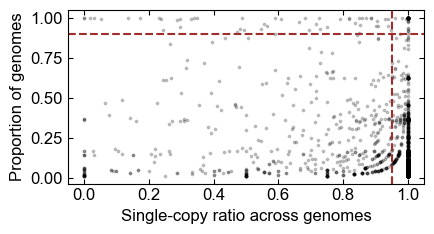

In [39]:
x = np.sum(adj_mod2 == 1, axis = 1) / np.sum(adj_mod2 >= 1, axis = 1)
y = np.sum(adj_mod2 >= 1, axis = 1) / adj_mod2.shape[1]
plt.figure(figsize = (4.5, 2.5))
plt.scatter(x, y, alpha = 0.2, color = 'k', s = 3, edgecolor = None)

# Threshold for presence and single-copy ratio
plt.axvline(x = 0.95, ls = 'dashed', color = '#a02c2cff')
plt.axhline(y = 0.90, ls = 'dashed', color = '#a02c2cff')
# plt.legend(title = 'Pfam type')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.xlabel('Single-copy ratio across genomes')
plt.ylabel('Proportion of genomes')
plt.savefig(f'./figures/figure_S2A.svg')
plt.show()